# Hücre-1: Setup + Import

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os, sys, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [16]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODELS_DIR = os.path.join(BASE_DIR, "models")
sys.path.insert(0, MODELS_DIR)

from relu import TinyCNN_ReLU
from leaky_relu import TinyCNN_LeakyReLU

print("BASE_DIR  :", BASE_DIR)
print("MODELS_DIR:", MODELS_DIR)

BASE_DIR  : c:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Core\LeakyReLU
MODELS_DIR: c:\Users\hdgn5\OneDrive\Belgeler\GitHub\pytorch-cnn-architecture-library\Torch_CNN\activation_functions\Core\LeakyReLU\models


# Hücre-2: Seed (adil kıyas için şart)

In [17]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

# Hücre-3: Dataset (örnek: CIFAR10)

In [18]:
BATCH_SIZE = 128
NUM_CLASSES = 10

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(test_loader)


Files already downloaded and verified
Files already downloaded and verified


(391, 79)

# Hücre-4: Train/Eval fonksiyonları

In [19]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct = 0, 0
    loss_sum = 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct / total


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_sum = 0.0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        total += x.size(0)
    return loss_sum / total


# Hücre-5: Modelleri oluştur (aynı init için state kopyası)

In [20]:
EPOCHS = 15
LR = 1e-3

set_seed(42)

relu_model = TinyCNN_ReLU(num_classes=NUM_CLASSES).to(device)
lrelu_model = TinyCNN_LeakyReLU(num_classes=NUM_CLASSES, negative_slope=0.1).to(device)

# Başlangıç ağırlıkları birebir aynı olsun:
lrelu_model.load_state_dict(relu_model.state_dict(), strict=True)

opt_relu  = optim.Adam(relu_model.parameters(), lr=LR)
opt_lrelu = optim.Adam(lrelu_model.parameters(), lr=LR)

print("Models ready.")

Models ready.


# Hücre-6: Eğitim döngüsü + log

In [21]:
history = {
    "relu_train_loss": [],
    "relu_test_loss": [],
    "relu_test_acc": [],
    "lrelu_train_loss": [],
    "lrelu_test_loss": [],
    "lrelu_test_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    tr_loss_relu  = train_one_epoch(relu_model, train_loader, opt_relu, device)
    te_loss_relu, te_acc_relu = evaluate(relu_model, test_loader, device)

    tr_loss_lrelu = train_one_epoch(lrelu_model, train_loader, opt_lrelu, device)
    te_loss_lrelu, te_acc_lrelu = evaluate(lrelu_model, test_loader, device)

    history["relu_train_loss"].append(tr_loss_relu)
    history["relu_test_loss"].append(te_loss_relu)
    history["relu_test_acc"].append(te_acc_relu)

    history["lrelu_train_loss"].append(tr_loss_lrelu)
    history["lrelu_test_loss"].append(te_loss_lrelu)
    history["lrelu_test_acc"].append(te_acc_lrelu)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"ReLU:  train_loss={tr_loss_relu:.4f} test_loss={te_loss_relu:.4f} acc={te_acc_relu:.4f} | "
        f"LReLU: train_loss={tr_loss_lrelu:.4f} test_loss={te_loss_lrelu:.4f} acc={te_acc_lrelu:.4f}"
    )

Epoch 01/15 | ReLU:  train_loss=1.5825 test_loss=1.3006 acc=0.5148 | LReLU: train_loss=1.6084 test_loss=1.3517 acc=0.4985
Epoch 02/15 | ReLU:  train_loss=1.2042 test_loss=1.2360 acc=0.5653 | LReLU: train_loss=1.2533 test_loss=1.1923 acc=0.5776
Epoch 03/15 | ReLU:  train_loss=1.0463 test_loss=1.1357 acc=0.6071 | LReLU: train_loss=1.0944 test_loss=1.1406 acc=0.6074
Epoch 04/15 | ReLU:  train_loss=0.9554 test_loss=0.9764 acc=0.6525 | LReLU: train_loss=0.9926 test_loss=0.9721 acc=0.6601
Epoch 05/15 | ReLU:  train_loss=0.8790 test_loss=0.8901 acc=0.6816 | LReLU: train_loss=0.9223 test_loss=0.8792 acc=0.6925
Epoch 06/15 | ReLU:  train_loss=0.8177 test_loss=0.9524 acc=0.6661 | LReLU: train_loss=0.8689 test_loss=0.8968 acc=0.6852
Epoch 07/15 | ReLU:  train_loss=0.7696 test_loss=0.8031 acc=0.7230 | LReLU: train_loss=0.8193 test_loss=0.8328 acc=0.7047
Epoch 08/15 | ReLU:  train_loss=0.7292 test_loss=0.7377 acc=0.7459 | LReLU: train_loss=0.7774 test_loss=0.8596 acc=0.7103
Epoch 09/15 | ReLU:  tra

# Hücre-7: Basit grafik

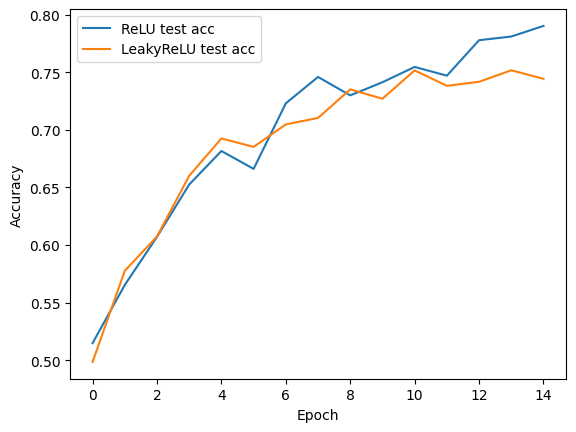

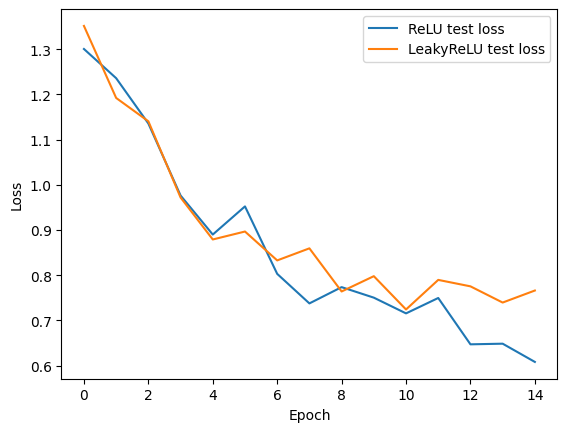

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["relu_test_acc"], label="ReLU test acc")
plt.plot(history["lrelu_test_acc"], label="LeakyReLU test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["relu_test_loss"], label="ReLU test loss")
plt.plot(history["lrelu_test_loss"], label="LeakyReLU test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()  

## Eğitim Sonuçları (15 Epoch)  
**ReLU vs LeakyReLU — Aynı veri seti, aynı epoch sayısı**

| Epoch | Model | Train Loss | Test Loss | Accuracy |
|------:|:------|-----------:|----------:|---------:|
| 1 | ReLU | 1.5825 | 1.3006 | 0.5148 |
| 1 | LeakyReLU | 1.6084 | 1.3517 | 0.4985 |
| 2 | ReLU | 1.2042 | 1.2360 | 0.5653 |
| 2 | LeakyReLU | 1.2533 | 1.1923 | 0.5776 |
| 3 | ReLU | 1.0463 | 1.1357 | 0.6071 |
| 3 | LeakyReLU | 1.0944 | 1.1406 | 0.6074 |
| 4 | ReLU | 0.9554 | 0.9764 | 0.6525 |
| 4 | LeakyReLU | 0.9926 | 0.9721 | 0.6601 |
| 5 | ReLU | 0.8790 | 0.8901 | 0.6816 |
| 5 | LeakyReLU | 0.9223 | 0.8792 | 0.6925 |
| 6 | ReLU | 0.8177 | 0.9524 | 0.6661 |
| 6 | LeakyReLU | 0.8689 | 0.8968 | 0.6852 |
| 7 | ReLU | 0.7696 | 0.8031 | 0.7230 |
| 7 | LeakyReLU | 0.8193 | 0.8328 | 0.7047 |
| 8 | ReLU | 0.7292 | 0.7377 | 0.7459 |
| 8 | LeakyReLU | 0.7774 | 0.8596 | 0.7103 |
| 9 | ReLU | 0.6974 | 0.7737 | 0.7299 |
| 9 | LeakyReLU | 0.7473 | 0.7641 | 0.7351 |
| 10 | ReLU | 0.6723 | 0.7505 | 0.7413 |
| 10 | LeakyReLU | 0.7149 | 0.7980 | 0.7270 |
| 11 | ReLU | 0.6427 | 0.7157 | 0.7546 |
| 11 | LeakyReLU | 0.6821 | 0.7243 | 0.7516 |
| 12 | ReLU | 0.6223 | 0.7497 | 0.7470 |
| 12 | LeakyReLU | 0.6672 | 0.7897 | 0.7382 |
| 13 | ReLU | 0.6028 | 0.6472 | 0.7778 |
| 13 | LeakyReLU | 0.6415 | 0.7755 | 0.7417 |
| 14 | ReLU | 0.5813 | 0.6486 | 0.7810 |
| 14 | LeakyReLU | 0.6248 | 0.7396 | 0.7517 |
| 15 | ReLU | 0.5706 | 0.6083 | 0.7902 |
| 15 | LeakyReLU | 0.6099 | 0.7662 | 0.7443 |


## Sonuç ve Değerlendirme (15 Epoch)

Bu deneyde ReLU ve LeakyReLU aktivasyon fonksiyonları, **aynı mimari**, **aynı veri seti**, **aynı başlangıç ağırlıkları**, **aynı optimizer ve epoch sayısı (15)** ile karşılaştırılmıştır. Amaç, aktivasyon fonksiyonunun öğrenme dinamikleri ve genelleme performansı üzerindeki etkisini izole şekilde incelemektir.


### Genel Gözlemler

- **Erken epoch’larda (1–6)** LeakyReLU, ReLU’ya kıyasla daha **stabil** bir öğrenme eğilimi göstermiştir.  
  Özellikle test doğruluğunda ani düşüşler daha sınırlıdır.
- **Orta epoch aralığında (7–10)** ReLU’nun test doğruluğunda **daha hızlı bir artış** gözlemlenmiştir.
- **Geç epoch’larda (11–15)** ReLU, hem test kaybı hem de doğruluk açısından LeakyReLU’nun önüne geçmiştir.



### Sayısal Karşılaştırma (Son Epoch)

- **ReLU**
  - Test Loss: **0.6083**
  - Test Accuracy: **0.7902**

- **LeakyReLU**
  - Test Loss: **0.7662**
  - Test Accuracy: **0.7443**

ReLU, 15. epoch sonunda yaklaşık **%4.6 mutlak doğruluk farkı** ile daha iyi bir sonuç elde etmiştir.


### Yorum (Neden Böyle Oldu?)

- **LeakyReLU**, negatif bölgede gradyan akışını tamamen kesmediği için:
  - Eğitim sürecinin **erken aşamalarında** daha güvenli ve stabil bir optimizasyon sağlar.
  - Kısa epoch’lu veya zor yakınsayan senaryolarda avantajlıdır.

- **ReLU** ise:
  - Eğitim ilerledikçe daha **keskin karar sınırları** oluşturur.
  - Yeterli epoch sayısı verildiğinde, daha yüksek **ayrım gücü** ve **nihai doğruluk** elde edebilir.
  - Bu deneyde, geç epoch’larda ReLU’nun daha iyi genelleme yapabildiği görülmüştür.



### Sonuç

- **Kısa ve orta vadeli eğitimlerde (az epoch)**  
  → **LeakyReLU**, stabilite açısından avantaj sağlayabilir.

- **Daha uzun eğitimlerde (yeterli epoch)**  
  → **ReLU**, daha yüksek nihai doğruluk elde edebilir.

Bu nedenle aktivasyon seçimi:
- yalnızca “hangisi daha iyi?” sorusuna değil,
- **eğitim süresi**, **optimizasyon zorluğu** ve **stabilite gereksinimlerine**

bağlı olarak yapılmalıdır.

> Not: Bu sonuçlar belirli bir mimari ve veri seti için geçerlidir. Farklı derinlikler, optimizer’lar veya regularization stratejileri altında sonuçlar değişebilir.
